<a href="https://colab.research.google.com/github/twisha96/Gated_Attention/blob/master/GANet_Trec_FF_Aux.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install torchtext==0.4

In [0]:
import math
import numpy as np
import pandas as pd
import pdb

import torch
import torch.nn.functional as F
import torch.distributions
import torch.optim as optim
from torch import nn 
from torch.autograd import Variable

import torchtext
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe

# from models.LSTM import LSTMClassifier

In [0]:
# model.py

class GANet(torch.nn.Module):
    def __init__(self, batch_size, num_classes, mlp_out_size, vocab_size, embedding_length, weights, aux_hidden_size = 100, backbone_hidden_size = 100, tau = 1, biDirectional_aux = False, biDirectional_backbone = False):
        super(GANet, self).__init__() 
        """
        Arguments
        ---------
        batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
        output_size : 6 = (For TREC dataset)
        hidden_sie : Size of the hidden_state of the LSTM   (// Later BiLSTM)
        vocab_size : Size of the vocabulary containing unique words
        embedding_length : Embeddding dimension of GloVe word embeddings
        weights : Pre-trained GloVe word_embeddings which we will use to create our word_embedding look-up table 

        --------

        """

        self.batch_size = batch_size
        self.num_classes = num_classes
        self.vocab_size = vocab_size
        self.embedding_length = embedding_length
        self.aux_hidden_size = aux_hidden_size
        self.backbone_hidden_size = backbone_hidden_size 
        self.mlp_out_size = mlp_out_size
        self.biDirectional_aux = biDirectional_aux
        self.biDirectional_backbone = biDirectional_backbone
        self.tau = tau

        self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
        self.word_embeddings.weights = nn.Parameter(weights, requires_grad=False)

        self.auxiliary = AuxiliaryNet(self.batch_size, self.aux_hidden_size, self.embedding_length, self.biDirectional_aux, tau = self.tau)
        self.backbone = BackboneNet(self.batch_size, self.backbone_hidden_size, self.embedding_length, self.biDirectional_backbone)

        if(self.biDirectional_backbone):
            self.mlp = MLP(self.backbone_hidden_size * 2, self.mlp_out_size)
            self.FF = nn.Linear(self.backbone_hidden_size * 2,num_classes)
        else:
            self.mlp = MLP(self.backbone_hidden_size, self.mlp_out_size)
            self.FF = nn.Linear(self.backbone_hidden_size,num_classes)
        self.tanh = nn.Tanh()

    def masked_Softmax(self, logits, mask):
        mask_bool = mask>0
        logits[~mask_bool] = float('-inf')
        return torch.softmax(logits, dim=1)

    
    def forward(self,input_sequence, is_train = True):
        input_ = self.word_embeddings(input_sequence)
        g_t, p_t = self.auxiliary(input_, is_train)
        out_lstm = self.backbone(input_)

        if is_train:
            e_t = self.mlp(out_lstm)
#             alpha = torch.softmax(e_t*g_t, dim = 1)
#             pdb.set_trace()
            alpha_numerator = torch.exp(e_t)*g_t
            alpha_denomenator = torch.sum(alpha_numerator, dim=1).repeat(e_t.shape[1],1,1).transpose(0,1)
            alpha = alpha_numerator/alpha_denomenator
        else:
            e_t = self.mlp(out_lstm)               # change if possible!
            alpha = self.masked_Softmax(e_t, g_t)
            
        c_t = torch.bmm(alpha.transpose(1,2), out_lstm)
        logits = self.FF(c_t)
        logits = self.tanh(logits)
        final_output = torch.softmax(logits, dim = -1)
        # final_output = final_output.max(2)[1]
        final_output = final_output.squeeze(1)

        return final_output, g_t, alpha, p_t

In [0]:
class AuxiliaryNet(torch.nn.Module):
    """
    Arguments
    ---------
    batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
    aux_hidden_size : Size of the hidden_state of the LSTM   (* Later BiLSTM, check dims for BiLSTM *)
    embedding_length : Embeddding dimension of GloVe word embeddings
    --------
    """
    def __init__(self, batch_size, auxiliary_hidden_size, embedding_length, biDirectional = False, num_layers = 1, tau=1):
        super(AuxiliaryNet, self).__init__()
        self.batch_size = batch_size
        self.hidden_size = auxiliary_hidden_size
        self.embedding_length = embedding_length
        self.biDirectional = biDirectional
        self.num_layers = num_layers
        
        self.mlp = Aux_MLP(self.embedding_length)

        self.sigmoid = torch.nn.Sigmoid()
        self.tau = tau


    def forward(self, input_sequence, is_train = True, batch_size=None):

        # input : Dimensions (batch_size x seq_len x embedding_length)
        # out_lstm, (final_hidden_state, final_cell_state) = self.aux_lstm(input_sequence) # ouput dim: (batch_size x seq_len x hidden_size) 
        
        out_mlp = self.mlp(input_sequence)                                           # p_t dim: (batch_size x seq_len x 1)
        p_t = self.sigmoid(out_mlp)

        if is_train:
            p_t = p_t.repeat(1,1,2)
            p_t[:,:,0] = 1 - p_t[:,:,0] 
            g_hat = F.gumbel_softmax(p_t, self.tau, hard=False)
#             print("p_t: ", p_t)
            g_t = g_hat[:,:,1]
            g_t = g_t.reshape(g_t.shape[0], g_t.shape[1], 1)
#             print("g_t Gumbel: ", g_t)
        else:
            # size : same as p_t [ batch_size x seq_len x 1]
#             print("Underlying probability distribution: ", p_t)
            m = torch.distributions.bernoulli.Bernoulli(p_t)   
#             pdb.set_trace()
            g_t = m.sample()
            
            # We do not want all the values of g_t for a sample to be 0
            # Make all g_t's 1 when all are zero
            gt_sum = g_t.sum(1)
            x = (gt_sum == 0).nonzero()
            x = x[:,0]
            for i in x:
                g_t[i,:,:] = torch.ones(g_t[i,:,:].shape)
#             print("All zero: ", len(x))
        return g_t, p_t

In [0]:
class BackboneNet(torch.nn.Module):
    """
        Arguments
        ---------
        batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
        backbone_hidden_size : Size of the hidden_state of the LSTM   (* Later BiLSTM, check dims for BiLSTM *)
        embedding_length : Embeddding dimension of GloVe word embeddings
        --------
    """
    def __init__(self, batch_size, backbone_hidden_size, embedding_length, biDirectional = False, num_layers = 2):

        super(BackboneNet, self).__init__()
        self.batch_size = batch_size
        self.hidden_size = backbone_hidden_size
        self.embedding_length = embedding_length
        self.biDirectional	= biDirectional
        self.num_layers = num_layers

        self.backbone_lstm = nn.LSTM(self.embedding_length, self.hidden_size, bidirectional = self.biDirectional, batch_first = True, num_layers = self.num_layers)   # Dropout  

    def forward(self, input_sequence, batch_size=None):
        out_lstm, (final_hidden_state, final_cell_state) = self.backbone_lstm(input_sequence)   # ouput dim: ( batch_size x seq_len x hidden_size )
        return out_lstm


In [0]:
class Aux_MLP(torch.nn.Module):
    def __init__(self, input_dim, layer1_dim= 64, layer2_dim = 32 ):
        super(Aux_MLP, self).__init__()

        self.input_dim = input_dim   # Embedding dimension
        self.layer1_dim = layer1_dim
        self.layer2_dim = layer2_dim

        # self.output_dim = output_dim  # 

        self.ff_1 = nn.Linear(self.input_dim, self.layer1_dim)
#         self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.ff_2 =  nn.Linear(self.layer1_dim,self.layer2_dim)
        self.ff_3 = nn.Linear(self.layer2_dim,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        out_1 = self.ff_1(x)
#         out_relu = self.relu(out_1)
#         out_2 = self.ff_2(out_relu)
        out_tanh_1 = self.tanh(out_1)
        out_2 = self.ff_2(out_tanh_1)
        out_tanh_2 = self.tanh(out_2)
        out_3 = self.ff_3(out_tanh_2)
#         out_sigmoid = self.sigmoid(out_2)

        return out_3

In [0]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim

        self.ff_1 = nn.Linear(self.input_dim, self.output_dim)
#         self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.ff_2 = nn.Linear(self.output_dim,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        out_1 = self.ff_1(x)
#         out_relu = self.relu(out_1)
#         out_2 = self.ff_2(out_relu)
        out_tanh = self.tanh(out_1)
        out_2 = self.ff_2(out_tanh)
#         out_sigmoid = self.sigmoid(out_2)

        return out_2 

In [0]:
def clip_gradient(model, clip_value):
    params = list(filter(lambda p: p.grad is not None, model.parameters()))
    for p in params:
        p.grad.data.clamp_(-clip_value, clip_value)
    
def train_model(model, optim, train_iter, epoch, batch_size):
    total_epoch_loss = 0
    total_epoch_acc = 0
    # model.cuda()
#     optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
    steps = 0
    model.train()
    for idx, batch in enumerate(train_iter):
        text = batch.text[0]
        target = batch.label
        target = torch.autograd.Variable(target).long()
        if torch.cuda.is_available():
            text = text.cuda()
            target = target.cuda()
        if (text.size()[0] is not batch_size):# One of the batch returned by BucketIterator has length different than 32.
            continue
        optim.zero_grad()
        prediction, g_t, alpha, p_t = model(text, is_train = True)
        # print("prediction = ", prediction.shape)
        # print("target = ", target.shape)
        # print("prediction = ", prediction)
        # print("target = ", target)
        
        # Modifies loss function
        loss = loss_fn(prediction, target, g_t)

        # Defualt - Cross entropy loss funtion
#         loss = loss_fn(prediction, target)
        
        # print("loss = ", loss)
        
        num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).float().sum()
        acc = 100.0 * num_corrects/len(batch)
        loss.backward()
        clip_gradient(model, 1e-1)
        optim.step()
        steps += 1
        
        # if steps % 10 == 0:
            # print (f'Epoch: {epoch+1}, Idx: {idx+1}, Training Loss: {loss.item():.4f}, Training Accuracy: {acc.item(): .2f}%')
            # break
        
        total_epoch_loss += loss.item()
        total_epoch_acc += acc.item()

    return total_epoch_loss/len(train_iter), total_epoch_acc/len(train_iter)

def eval_model(model, val_iter):
    total_epoch_loss = 0
    total_epoch_acc = 0
    total_attention =  0
    total_samples = 0 
    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(val_iter):
            text = batch.text[0]
            target = batch.label
            target = torch.autograd.Variable(target).long()
            if torch.cuda.is_available():
                text = text.cuda()
                target = target.cuda()
            prediction, g_t, alpha, p_t = model(text, is_train = False)
            # Sanity check
            # print("Test Prediction: ", prediction)
            # print("Gate values: ", g_t)

            # For density calculation
            total_attention += torch.sum(g_t)
            # print(total_attention)
            # print(g_t.shape)
            total_samples += g_t.shape[0] * g_t.shape[1]
            
            # Modifies loss function
            loss = loss_fn(prediction, target, g_t)

            # Defualt - Cross entropy loss funtion
#             loss =  loss_fn(prediction, target)
            
            if math.isnan(loss.item()):
                print(prediction, target)
            
            num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).sum()
            acc = 100.0 * num_corrects/len(batch)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()
            
    return total_epoch_loss/len(val_iter), total_epoch_acc/len(val_iter), total_attention/total_samples 

In [0]:
# data.py
def load_TREC_data(batch_size= 16, embedding_length = 100):
    # set up fields
    tokenize = lambda x: x.split()
    TEXT = data.Field(sequential=True, tokenize=tokenize, lower=True, include_lengths=True, batch_first=True, fix_length= 10)
    # LABEL = data.LabelField()
    LABEL = data.LabelField(dtype=torch.float)

    # make splits for data
    train, test = datasets.TREC.splits(TEXT, LABEL)
    train, valid = train.split() 
    
    # build the vocabulary
    TEXT.build_vocab(train, vectors=GloVe(name='6B', dim=embedding_length))
    LABEL.build_vocab(train)
    print(LABEL.vocab.__dict__)

    # make iterator for splits
    train_iter, valid_iter, test_iter = data.BucketIterator.splits(
      (train, valid, test), batch_size= batch_size, device=0)

    word_embeddings = TEXT.vocab.vectors
    vocab_size = len(TEXT.vocab)

    return TEXT, vocab_size, word_embeddings, train_iter, valid_iter, test_iter

In [10]:
# main.py
TEXT, vocab_size, word_embeddings, train_iter, valid_iter, test_iter = load_TREC_data()

downloading train_5500.label


train_5500.label: 100%|██████████| 336k/336k [00:00<00:00, 4.30MB/s]
TREC_10.label: 100%|██████████| 23.4k/23.4k [00:00<00:00, 1.17MB/s]


downloading TREC_10.label


.vector_cache/glove.6B.zip: 862MB [06:28, 2.22MB/s]                          
100%|█████████▉| 399218/400000 [00:18<00:00, 21566.37it/s]WARNING:torchtext.data.iterator:The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


{'freqs': Counter({'ENTY': 871, 'HUM': 835, 'DESC': 832, 'NUM': 624, 'LOC': 598, 'ABBR': 56}), 'itos': ['ENTY', 'HUM', 'DESC', 'NUM', 'LOC', 'ABBR'], 'unk_index': None, 'stoi': defaultdict(None, {'ENTY': 0, 'HUM': 1, 'DESC': 2, 'NUM': 3, 'LOC': 4, 'ABBR': 5}), 'vectors': None}


In [0]:
def loss_fn(output, target, g_t, lambda_ = 1e-4):
    T = g_t.shape[0]*g_t.shape[1]
    # loss = -nn.LogSoftmax(output[target], dim = 1) + (lambda_ * torch.sum(g_t))/T
    loss = F.cross_entropy(output, target) + (lambda_ * (torch.sum(g_t)/T))
    return loss

In [0]:
# Over-writing the loss function to simple cross entropy loss
# loss_fn = F.cross_entropy

learning_rate = 2e-5
batch_size = 16
output_size = 6
hidden_size = 256
embedding_length = 100
num_classes = 6
mlp_out_size = 32
weights = word_embeddings
aux_hidden_size = 100
batch_hidden_size = 100
tau = 1

model = GANet(batch_size, num_classes, mlp_out_size, vocab_size, embedding_length, weights, tau= tau, biDirectional_aux=True, biDirectional_backbone=True)
optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))

In [13]:
num_bad_epochs = 0
epoch = 0
least_loss = float('inf')
training_stats = pd.DataFrame(columns=['Epoch', 'Train_Loss', 'Train_Acc', 'Val_Loss', 'Val_Acc', 'Val_Density'])

while(True):
    train_loss, train_acc = train_model(model, optim, train_iter, epoch, batch_size)
    val_loss, val_acc, val_density = eval_model(model, valid_iter) 
    print(f'Epoch: {epoch+1:02}')
    if val_loss < least_loss:
        least_loss = val_loss
        num_bad_epochs = 0
        print("*** Least validation loss")
        torch.save(model.state_dict(), "BiLSTM+BiLSTM_BS_16")
    else:
        num_bad_epochs += 1
#     print(f'Epoch: {epoch+1:2}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%')
    print(f'Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%') 
    print(f'Val Loss: {val_loss:3f}, Val Acc: {val_acc:.2f}%, Val Density: {val_density:.4f}')
    print("-------------")
    
    training_stats = training_stats.append(
        pd.Series([epoch+1, train_loss, train_acc, val_loss, val_acc, val_density], index=training_stats.columns), 
        ignore_index=True)
#     if num_bad_epochs >= 10:
#         break
        
    epoch += 1
    if epoch == 50:
        break

Epoch: 01
*** Least validation loss
Train Loss: 1.628, Train Acc: 52.59%
Val Loss: 1.556285, Val Acc: 65.72%, Val Density: 0.4880
-------------


100%|█████████▉| 399218/400000 [00:30<00:00, 21566.37it/s]

Epoch: 02
*** Least validation loss
Train Loss: 1.526, Train Acc: 71.10%
Val Loss: 1.527702, Val Acc: 71.91%, Val Density: 0.4930
-------------
Epoch: 03
*** Least validation loss
Train Loss: 1.496, Train Acc: 76.41%
Val Loss: 1.523074, Val Acc: 72.51%, Val Density: 0.4616
-------------
Epoch: 04
*** Least validation loss
Train Loss: 1.481, Train Acc: 79.34%
Val Loss: 1.515676, Val Acc: 74.09%, Val Density: 0.4869
-------------
Epoch: 05
Train Loss: 1.470, Train Acc: 81.67%
Val Loss: 1.516554, Val Acc: 73.67%, Val Density: 0.4902
-------------
Epoch: 06
*** Least validation loss
Train Loss: 1.457, Train Acc: 84.13%
Val Loss: 1.508507, Val Acc: 75.18%, Val Density: 0.4530
-------------
Epoch: 07
*** Least validation loss
Train Loss: 1.448, Train Acc: 86.11%
Val Loss: 1.503547, Val Acc: 76.40%, Val Density: 0.4620
-------------
Epoch: 08
*** Least validation loss
Train Loss: 1.441, Train Acc: 87.21%
Val Loss: 1.501201, Val Acc: 77.12%, Val Density: 0.5057
-------------
Epoch: 09
*** Leas

In [0]:
training_stats.to_csv("BiLSTM+BiLSTM_BS_16.csv")

In [0]:
# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# # Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optim.state_dict():
#     print(var_name, "\t", optim.state_dict()[var_name])

In [16]:
loaded_model = GANet(batch_size, num_classes, mlp_out_size, vocab_size, embedding_length, weights, tau= tau, biDirectional_aux=True, biDirectional_backbone=True)
loaded_model.load_state_dict(torch.load('BiLSTM+BiLSTM_BS_16'))
loaded_model.eval()

GANet(
  (word_embeddings): Embedding(6944, 100)
  (auxiliary): AuxiliaryNet(
    (mlp): Aux_MLP(
      (ff_1): Linear(in_features=100, out_features=64, bias=True)
      (tanh): Tanh()
      (ff_2): Linear(in_features=64, out_features=32, bias=True)
      (ff_3): Linear(in_features=32, out_features=1, bias=True)
      (sigmoid): Sigmoid()
    )
    (sigmoid): Sigmoid()
  )
  (backbone): BackboneNet(
    (backbone_lstm): LSTM(100, 100, num_layers=2, batch_first=True, bidirectional=True)
  )
  (mlp): MLP(
    (ff_1): Linear(in_features=200, out_features=32, bias=True)
    (tanh): Tanh()
    (ff_2): Linear(in_features=32, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
  (FF): Linear(in_features=200, out_features=6, bias=True)
  (tanh): Tanh()
)

In [17]:
test_loss, test_acc, density = eval_model(loaded_model, test_iter)
print(f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.2f}, Density: {density:.4f} ')

Test Loss: 1.467, Test Acc: 83.59, Density: 0.5516 


In [18]:
def test_sentence(test_sen):
    test_sen_list = TEXT.preprocess(test_sen)
    print(test_sen_list)
    test_sen = [[TEXT.vocab.stoi[x] for x in test_sen_list]]
    # print(test_sen)

    test_sen = np.asarray(test_sen)
    test_sen = torch.LongTensor(test_sen)
    test_tensor = Variable(test_sen, volatile=True)

    # print(test_tensor)
    loaded_model.eval()
    prediction, g_t, alpha, p_t = loaded_model(test_tensor, is_train = False)
    print("prediction =", prediction)
#     print("g =", g_t)
    
    for i in range(len(test_sen_list)):
        print(test_sen_list[i], int(g_t[0][i]), float(p_t[0][i][0]), float(alpha[0][i][0]))
    out_class = torch.argmax(prediction)
    return out_class

# ['ENTY', 'HUM', 'DESC', 'NUM', 'LOC', 'ABBR']
test_sen0 = "What does the six-footed Musca domestica become when it enters a house ?" # class = Entity - 0
test_sen1 = "Who killed Gandhi ?"   # Class: HUM - 1
test_sen2 = "What does target heart rate mean ?" # class = "DESC" - 2
test_sen3 = "How old was Joan of Arc when she died ?" # class = "NUM" - 3
test_sen4 = "Where on the body is a mortarboard worn ?" # class = "LOC" - 4
test_sen5 = "What does I.V. stand for ?" # class = "ABBR" - 5
x = test_sentence(test_sen0)
print(x)
print('------------')
x = test_sentence(test_sen1)
print(x)
print('------------')
x = test_sentence(test_sen2)
print(x)
print('------------')
x = test_sentence(test_sen3)
print(x)
print('------------')
x = test_sentence(test_sen4)
print(x)
print('------------')
x = test_sentence(test_sen5)
print(x)
print('------------')

['what', 'does', 'the', 'six-footed', 'musca', 'domestica', 'become', 'when', 'it', 'enters', 'a', 'house', '?']
prediction = tensor([[0.5963, 0.0807, 0.0809, 0.0807, 0.0807, 0.0807]],
       grad_fn=<SqueezeBackward1>)
what 0 0.003976395819336176 0.0
does 0 0.0021155120339244604 0.0
the 0 0.0269416905939579 0.0
six-footed 1 0.9900999665260315 0.11721692979335785
musca 1 0.9900999665260315 0.15338003635406494
domestica 1 0.9900999665260315 0.14226682484149933
become 1 0.9969335794448853 0.1218630000948906
when 1 0.9983291029930115 0.3299843668937683
it 1 0.9951359629631042 0.11924856901168823
enters 1 0.9900999665260315 0.01604028232395649
a 0 0.008908516727387905 0.0
house 0 0.0013946479884907603 0.0
? 0 0.0009937817230820656 0.0
tensor(0, grad_fn=<NotImplemented>)
------------
['who', 'killed', 'gandhi', '?']
prediction = tensor([[0.0807, 0.5964, 0.0807, 0.0807, 0.0807, 0.0807]],
       grad_fn=<SqueezeBackward1>)
who 0 0.002099711913615465 0.0
killed 1 0.9991368651390076 0.564411282

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


In [19]:
training_stats

,Epoch,Train_Loss,Train_Acc,Val_Loss,Val_Acc,Val_Density
0,1,1.627947,52.588912,1.556285,65.716019,tensor(0.4880)
1,2,1.526138,71.103556,1.527702,71.905340,tensor(0.4930)
2,3,1.496183,76.412134,1.523074,72.512136,tensor(0.4616)
3,4,1.481103,79.341004,1.515676,74.089806,tensor(0.4869)
4,5,1.469833,81.668410,1.516554,73.665049,tensor(0.4902)
5,6,1.456722,84.126569,1.508507,75.182039,tensor(0.4530)
6,7,1.447627,86.114017,1.503547,76.395631,tensor(0.4620)
7,8,1.441346,87.212343,1.501201,77.123786,tensor(0.5057)
8,9,1.432639,88.833682,1.498095,77.912621,tensor(0.5100)
9,10,1.428836,89.670502,1.499159,77.305825,tensor(0.5139)


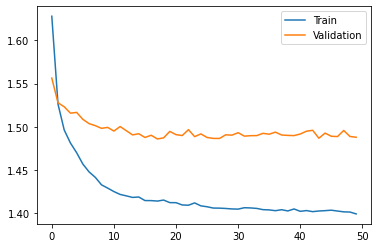

In [20]:
import matplotlib.pyplot as plt
plt.plot(training_stats['Train_Loss'], label="Train")
plt.plot(training_stats['Val_Loss'], label="Validation")
plt.legend()
plt.show()

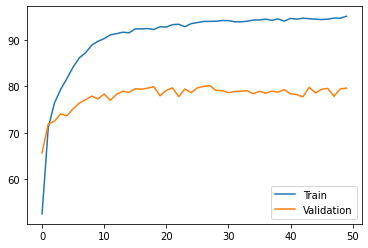

In [21]:
plt.plot(training_stats['Train_Acc'], label="Train")
plt.plot(training_stats['Val_Acc'], label="Validation")
plt.legend()
plt.show()

In [22]:
t = torch.rand(2,3,4)
t

tensor([[[0.2110, 0.6173, 0.4820, 0.6794],
         [0.2456, 0.4800, 0.4455, 0.1892],
         [0.9780, 0.4053, 0.1661, 0.5889]],

        [[0.4965, 0.2578, 0.3643, 0.2801],
         [0.6266, 0.2672, 0.8421, 0.2898],
         [0.4596, 0.7725, 0.8926, 0.2083]]])

In [23]:
torch.exp(t)

tensor([[[1.2350, 1.8538, 1.6194, 1.9726],
         [1.2784, 1.6160, 1.5613, 1.2083],
         [2.6591, 1.4998, 1.1807, 1.8019]],

        [[1.6429, 1.2941, 1.4395, 1.3233],
         [1.8713, 1.3063, 2.3213, 1.3362],
         [1.5834, 2.1651, 2.4414, 1.2316]]])

In [24]:
torch.sum(torch.exp(t), dim=1)

tensor([[5.1724, 4.9697, 4.3613, 4.9829],
        [5.0976, 4.7655, 6.2023, 3.8911]])

In [25]:
torch.sum(torch.exp(t), dim=1).repeat(3,1,1).transpose(0,1)

tensor([[[5.1724, 4.9697, 4.3613, 4.9829],
         [5.1724, 4.9697, 4.3613, 4.9829],
         [5.1724, 4.9697, 4.3613, 4.9829]],

        [[5.0976, 4.7655, 6.2023, 3.8911],
         [5.0976, 4.7655, 6.2023, 3.8911],
         [5.0976, 4.7655, 6.2023, 3.8911]]])

In [26]:
torch.exp(t)/torch.sum(torch.exp(t), dim=1).repeat(3,1,1).transpose(0,1)

tensor([[[0.2388, 0.3730, 0.3713, 0.3959],
         [0.2472, 0.3252, 0.3580, 0.2425],
         [0.5141, 0.3018, 0.2707, 0.3616]],

        [[0.3223, 0.2716, 0.2321, 0.3401],
         [0.3671, 0.2741, 0.3743, 0.3434],
         [0.3106, 0.4543, 0.3936, 0.3165]]])

In [0]:
# g_t = torch.tensor([[[1.],
#          [0.],
#          [1.],
#          [0.],
#          [1.],
#          [0.],
#          [1.],
#          [0.],
#          [0.],
#          [0.]],

#         [[0.],
#          [1.],
#          [1.],
#          [1.],
#          [0.],
#          [1.],
#          [1.],
#          [0.],
#          [1.],
#          [1.]],

#         [[0.],
#          [0.],
#          [0.],
#          [0.],
#          [0.],
#          [0.],
#          [0.],
#          [0.],
#          [0.],
#          [0.]]])

In [0]:
# g_t.shape

In [0]:
# g_t_sum = g_t.sum(1)

In [0]:
# g_t_sum

In [0]:
# x = (g_t_sum == 0).nonzero()

In [0]:
# x = x[:,0]

In [0]:
# x

In [0]:
# for i in x:
#     print("Old g", g_t[i,:,:])
#     new_g = torch.ones(g_t[i,:,:].shape)
#     g_t[i,:,:] = new_g
#     print("New g", g_t[i,:,:])

In [35]:
logits = torch.rand(3, 2, 1)
print(logits)

tensor([[[0.7669],
         [0.0441]],

        [[0.4030],
         [0.8371]],

        [[0.2873],
         [0.9665]]])


In [36]:
logits = logits.repeat(1,1,2)
logits[:,:,0] = 1 - logits[:,:,0] 
print(logits)

tensor([[[0.2331, 0.7669],
         [0.9559, 0.0441]],

        [[0.5970, 0.4030],
         [0.1629, 0.8371]],

        [[0.7127, 0.2873],
         [0.0335, 0.9665]]])


In [37]:
# Sample soft categorical using reparametrization trick:
F.gumbel_softmax(logits, tau=1, hard=False)

tensor([[[0.4426, 0.5574],
         [0.3521, 0.6479]],

        [[0.5117, 0.4883],
         [0.7114, 0.2886]],

        [[0.1633, 0.8367],
         [0.2770, 0.7230]]])

In [38]:
# Sample soft categorical using reparametrization trick:
F.gumbel_softmax(logits, tau=1, hard=False)

tensor([[[0.8818, 0.1182],
         [0.6876, 0.3124]],

        [[0.8448, 0.1552],
         [0.0220, 0.9780]],

        [[0.1111, 0.8889],
         [0.3510, 0.6490]]])

In [39]:
# Sample hard categorical using "Straight-through" trick:
F.gumbel_softmax(logits, tau=1, hard=True)

tensor([[[1., 0.],
         [1., 0.]],

        [[1., 0.],
         [1., 0.]],

        [[1., 0.],
         [0., 1.]]])

In [40]:
# Sample hard categorical using "Straight-through" trick:
F.gumbel_softmax(logits, tau=1, hard=True)

tensor([[[0., 1.],
         [1., 0.]],

        [[1., 0.],
         [0., 1.]],

        [[1., 0.],
         [0., 1.]]])